# **Метод К-ближайших соседей**

## Содержание
1. Описание датасета. Загрузка данных.
2. Разделение выборки на тестовую и обучающую. Масштабирование данных
3. Результаты с произвольно выбранным К.
4. Подбор гиперпараметра К с использованием GridSearchCV и/или RandomizedSearchCV и кросс-валидации.
5. Сравнение метрики качества исходной и оптимальной моделей.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('googleplaystore.csv')

In [3]:
# ОЧИЩАЕМ ДАТАСЕТ, КАК В ЛАБ. РАБОТАХ №1 И №"2
# Предположу, что данные версии андроида, обновления и версии нас мало интерисуют, удалим эти столбцы
# удаление столбца
df = df.drop('Android Ver', axis=1)
df = df.drop('Current Ver', axis=1)
df = df.drop('Last Updated', axis=1)

# Как видно, столбец Reviews и прочие имеют тип object, хотя в них числовые значения
# Уберем букву "M", которая обозначает миллион или мегабайт, чтобы остались сухие числа

# удаление строк, содержащих "Varies with device"
df = df[df['Size'] != 'Varies with device']
df = df[df['Price'] != 'Everyone']

# сохранение изменений в исходном файле
#df.to_csv('dataset.csv', index=False)


if df['Size'].dtypes == 'object':
    df['Size'] = df['Size'].str.replace('M', '')
    df['Size'] = df['Size'].str.replace('k', '')
    df['Size'] = df['Size'].str.replace('+', '')
    df['Size'] = df['Size'].str.replace(',', '.')
    df['Size'] = df['Size'].astype(float)

if df['Reviews'].dtypes == 'object':
    df['Reviews'] = df['Reviews'].str.replace('M', '')
    df['Reviews'] = df['Reviews'].astype(int)

if df['Price'].dtypes == 'object':
    df['Price'] = df['Price'].str.replace('$', '')
    df['Price'] = df['Price'].astype(float)
    
if df['Installs'].dtypes == 'object':
    df['Installs'] = df['Installs'].str.replace('M', '')
    df['Installs'] = df['Installs'].str.replace('+', '')
    df['Installs'] = df['Installs'].str.replace(',', '')
    df['Installs'] = df['Installs'].astype(int) # значения в этой колонке слишком большие для float, да и не за чем он тут

if df['Type'].dtypes == 'object':
    df['Type'] = df['Type'].str.replace('Free', 'True') # => True будет значить, что приложение бесплатное 
    df['Type'] = df['Type'].str.replace('Paid', 'False') # => False будет значить, что приложение платное
    df['Type'] = df['Type'].astype(bool)

df = df.dropna()

df = df.drop_duplicates()

# очистили датасет, теперь он готов для построения графиков

In [4]:
# Напомним себе содержание датасета
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000,True,0.0,Everyone,Art & Design
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,True,0.0,Everyone,Art & Design;Pretend Play
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000,True,0.0,Everyone,Art & Design
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000,True,0.0,Teen,Art & Design
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000,True,0.0,Everyone,Art & Design;Creativity


Для целей обучения и удобства визуализации я в начале возьму в качестве известных признаков BMI & BP. Результирующим параметром у нас является параметр Y

In [5]:
#  выбираем только три столбца из df и создаем новый DataFrame data_for_lab, содержащий только эти три столбца
data_for_lab = df[['Installs', 'Rating', 'Reviews']]

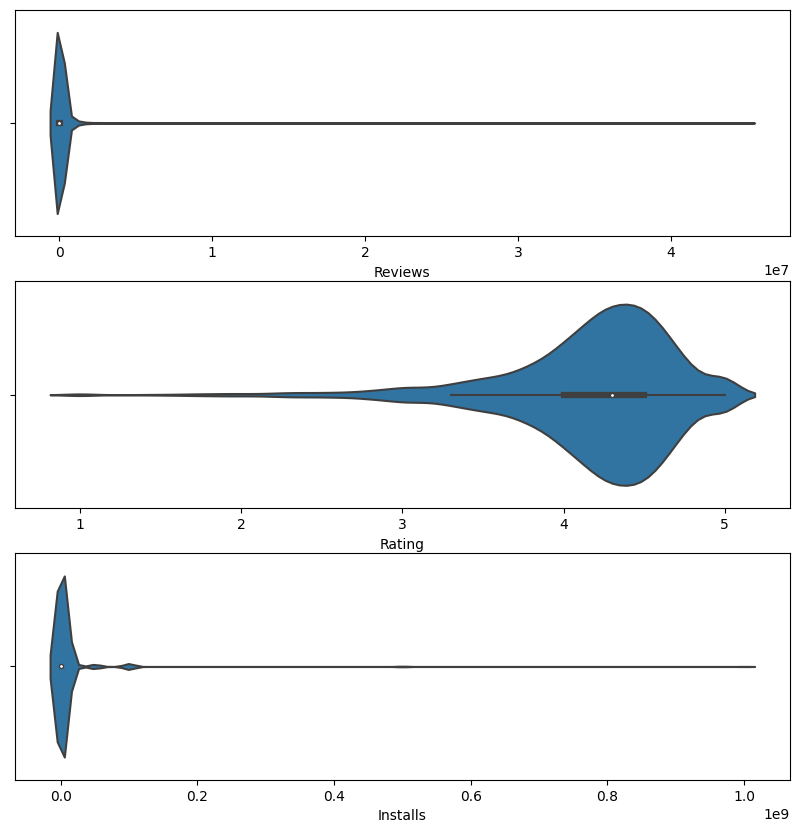

In [6]:
# создаем фигуру с тремя графиками, каждый график представляет одну из трех переменных. Функция subplots() создает три графика, 
# которые располагаются в одном столбце (3, 1), и каждый график имеет размер 10 на 10.
fig, ax = plt.subplots(3, 1, figsize=(10,10))
# создаем график скрипки для первой переменной (Installs). Аргумент ax указывает, в каком графике отображать этот график скрипки. Аргумент x указывает, какую переменную использовать для оси x.
# Аналогично, создаем график скрипки для второй переменной (Rating), а следующая строка кода создает график скрипки для третьей переменной (Reviews).
sns.violinplot(ax=ax[0], x=data_for_lab['Reviews'])
sns.violinplot(ax=ax[1], x=data_for_lab['Rating'])
sns.violinplot(ax=ax[2], x=data_for_lab['Installs'])
plt.show()

Можем заметить что признаки отличаются друг от друга по масштабу, поэтому необходимо привести их к единому методом стандартизации, так как это оптимальный способ масштабирования для нашего метода. 

<Axes: xlabel='Reviews', ylabel='Rating'>

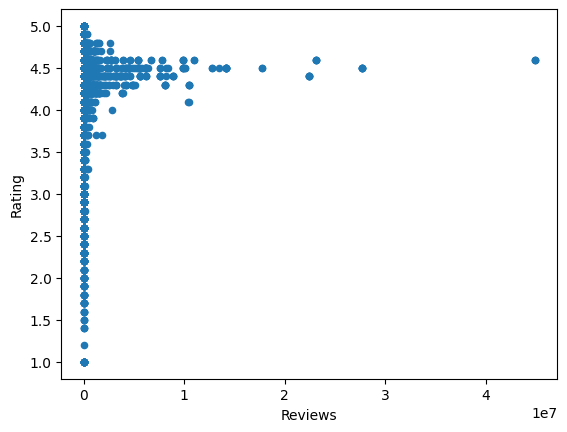

In [7]:
#Стандартизация с помощью класса StandartScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data_for_lab.drop('Installs', axis=1))
scaled_data = pd.DataFrame(scaled, columns = data_for_lab.drop('Installs', axis=1).columns)
data_for_lab.plot.scatter(x="Reviews", y="Rating")


<Axes: xlabel='Reviews', ylabel='Rating'>

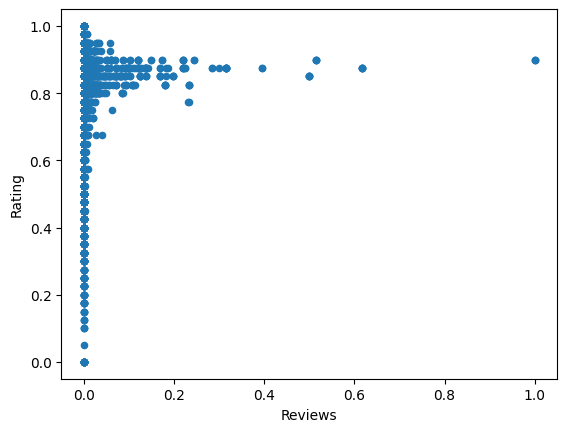

In [8]:
# строим scatter plot (диаграмму рассеяния) с помощью метода `plot.scatter()
scaled_data.plot.scatter(x="Reviews", y="Rating")

## 2. Разделение выборки на тестовую и обучающую.


Выполним разбиение с поомщью функции sklearn.model_selection.train_test_split, объем тестовой выборки зададим равным 0.3 от общего объема.

In [9]:
x = scaled_data
y = data_for_lab['Installs']

# test_size = 0.3 указывает, что 30% данных будут использоваться для тестирования модели, а 70% - для ее обучения.
x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(x, y, test_size = 0.3)

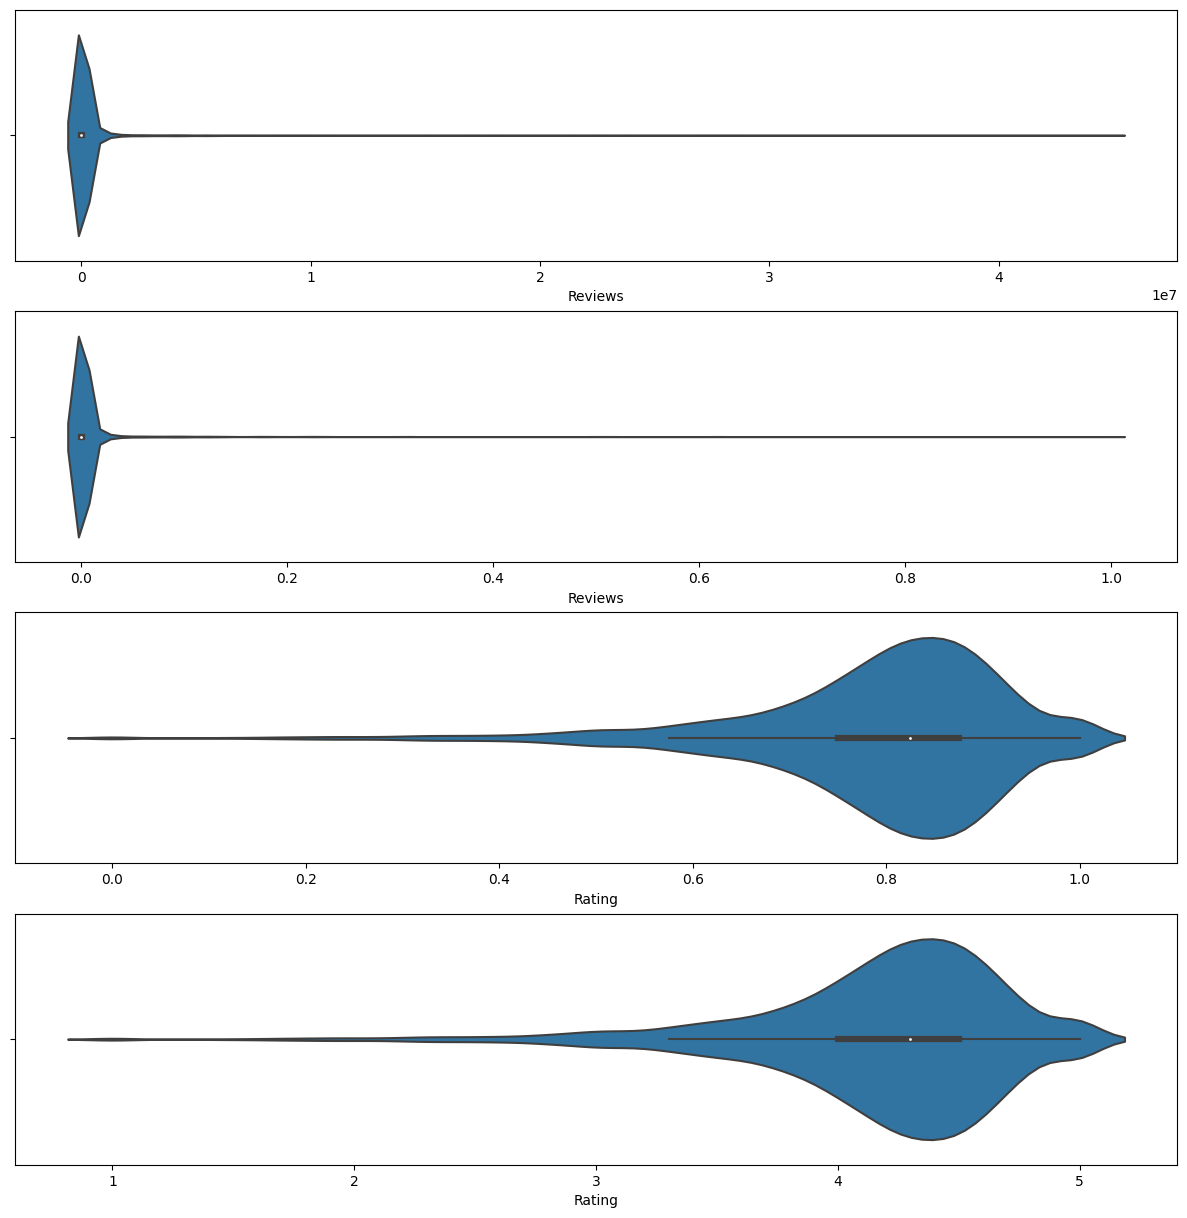

In [10]:
fig, ax = plt.subplots(4, 1, figsize=(15, 15))
sns.violinplot(ax=ax[0], x=data_for_lab['Reviews'])
sns.violinplot(ax=ax[1], x=scaled_data['Reviews'])
sns.violinplot(ax=ax[2], x=scaled_data['Rating'])
sns.violinplot(ax=ax[3], x=data_for_lab['Rating'])

plt.show()

## Обучение

In [11]:
# создадим объект KNeighborsRegressor из библиотеки sklearn с параметром n_neighbors = 100, 
# который определяет количество ближайших соседей, используемых для прогнозирования значения целевой переменной
KNeighborsRegressorObj = KNeighborsRegressor(n_neighbors=100) 
# Затем метод fit() применяется к обучающим данным
KNeighborsRegressorObj.fit(x_training_data, y_training_data)
# После обучения модели метод predict() используется для прогнозирования значений целевой переменной на тестовых данных x_test_data. 
# Результаты прогнозирования сохраняются в переменной y_predictions.
y_predictions = KNeighborsRegressorObj.predict(x_test_data)


In [12]:
# Используем несколько функций из библиотеки sklearn.metrics для оценки качества прогнозов модели.
# Функция r2_score() используется для вычисления коэффициента детерминации (R-квадрат), который измеряет, насколько хорошо модель соответствует данным.
# Функция mean_absolute_error() используется для вычисления средней абсолютной ошибки (MAE), которая измеряет среднее абсолютное отклонение прогнозов модели от фактических значений
# Функция mean_squared_error() используется для вычисления среднеквадратичной ошибки (MSE), которая измеряет среднее квадратичное отклонение прогнозов модели от фактических значений.

print(
r2_score(y_test_data, y_predictions, multioutput='raw_values'),
mean_absolute_error(y_test_data, y_predictions, multioutput='raw_values'),
mean_squared_error(y_test_data, y_predictions, multioutput='raw_values'))

[0.44342556] [3778117.45690166] [8.47322905e+14]


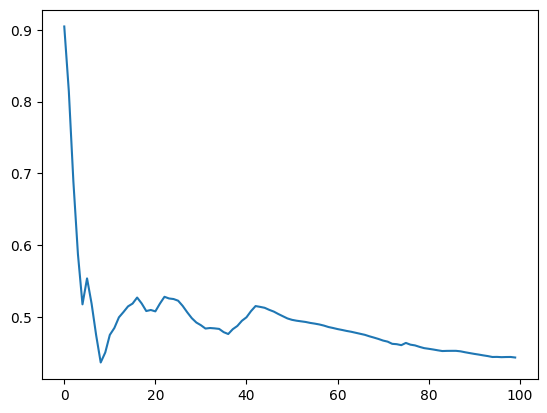

In [13]:
# Построим график зависимости коэффициента детерминации от количества ближайших соседей
error_rates = []
for i in np.arange(1, 101):
    new_model = KNeighborsRegressor(n_neighbors = i)
    new_model.fit(x_training_data, y_training_data)
    new_predictions = new_model.predict(x_test_data)
    error_rates.append(r2_score(y_test_data, new_predictions))
plt.plot(error_rates)

# На оси x отображается количество ближайших соседей, а на оси y - значения коэффициента детерминации. 
# График позволяет определить оптимальное количество соседей для данной модели.